In [1]:
%matplotlib inline
%pwd

'/home/gabe/work/fast-ai/nbs'

In [2]:
%%html
<style>
  .end_space {
      min-height: 1000px;
  }
  .container {
      width: 100%;
  }
</style

In [84]:
import sys
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from os import listdir, makedirs
from os.path import join, abspath, exists, isdir, isfile

np.random.seed(seed=2017)
sys.path.append('../src')

In [188]:
import utils.dogbreed
reload(utils.dogbreed)

import utils.trainhelper
reload(utils.trainhelper)

import utils.utils
reload(utils.utils)

from utils.dogbreed import *
from utils.trainhelper import save_model, read_model, get_classes, get_batches, get_data, un_onehot
from utils.utils import save_array, load_array, read_img

In [143]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import xception, inception_v3
from keras.utils import to_categorical as onehot

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

### Read data

In [118]:
DATA_DIR = '../data/dogbreed'
SAMPLE_DIR = join(DATA_DIR, 'sample')

BATCH_SIZE = 64
BATCH_SIZE_2X = BATCH_SIZE * 2

IMG_SIZE = 224
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

NUM_CLASSES = 120
SEED = 1987

In [13]:
train_dir = join(DATA_DIR, 'train')
valid_dir = join(DATA_DIR, 'valid')
test_dir = join(DATA_DIR, 'test')
save_dir = join(DATA_DIR, 'imgsave')

train_batches = get_batches(train_dir, batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=True)
valid_batches = get_batches(valid_dir, batch_size=BATCH_SIZE_2X, target_size=TARGET_SIZE, shuffle=False)
test_batches = get_batches(test_dir, batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=False, class_mode=None)

train_steps = np.ceil(train_batches.samples/BATCH_SIZE).astype('int')
valid_steps = np.ceil(valid_batches.samples/BATCH_SIZE_2X).astype('int')
test_steps = np.ceil(test_batches.samples/BATCH_SIZE).astype('int')

(
    train_classes,
    valid_classes,
    train_labels,
    valid_labels,
    train_filnames,
    valid_filnames,
    test_filnames,
) = get_classes(DATA_DIR)


Found 8221 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
Found 8221 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.


### Build a model based on VGG19

In [37]:
vgg = VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape=(TARGET_SIZE + (3,)))

x = vgg.output
x = Dense(NUM_CLASSES, activation='softmax')(x)

for layer in vgg.layers:
    layer.trainable = False

model = Model(inputs = vgg.input, outputs = x)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# train_vgg_preds = vgg.predict_generator(train_batches, train_steps)
# valid_vgg_preds = vgg.predict_generator(valid_batches, valid_steps)
# test_vgg_preds = vgg.predict_generator(test_batches, test_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [38]:
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=3, validation_data=valid_batches, validation_steps=valid_steps)

Epoch 1/3
129/129 [==============================] - 36s - loss: 11.4620 - acc: 0.0702 - val_loss: 9.5086 - val_acc: 0.1269
Epoch 2/3
129/129 [==============================] - 36s - loss: 8.2445 - acc: 0.2194 - val_loss: 7.9798 - val_acc: 0.2194
Epoch 3/3
129/129 [==============================] - 37s - loss: 6.7800 - acc: 0.3441 - val_loss: 7.4096 - val_acc: 0.2614


In [17]:
model.optimizer.lr = 1e-2
model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=10, validation_data=valid_batches, validation_steps=valid_steps)

Epoch 1/10
129/129 [==============================] - 33s - loss: 7.1931 - acc: 0.3810 - val_loss: 8.1030 - val_acc: 0.2639
Epoch 2/10
129/129 [==============================] - 32s - loss: 6.8159 - acc: 0.4356 - val_loss: 8.0359 - val_acc: 0.2739
Epoch 3/10
129/129 [==============================] - 33s - loss: 6.5017 - acc: 0.4784 - val_loss: 7.8790 - val_acc: 0.2914
Epoch 4/10
129/129 [==============================] - 32s - loss: 6.4260 - acc: 0.5115 - val_loss: 7.8910 - val_acc: 0.2909
Epoch 5/10
129/129 [==============================] - 33s - loss: 6.3216 - acc: 0.5345 - val_loss: 7.8685 - val_acc: 0.2984
Epoch 6/10
129/129 [==============================] - 32s - loss: 6.2406 - acc: 0.5596 - val_loss: 7.8707 - val_acc: 0.2984
Epoch 7/10
129/129 [==============================] - 32s - loss: 6.0931 - acc: 0.5864 - val_loss: 7.8461 - val_acc: 0.3003
Epoch 8/10
129/129 [==============================] - 32s - loss: 6.1086 - acc: 0.6004 - val_loss: 7.8264 - val_acc: 0.3098
Epoch 9/

In [294]:
print(train_vgg_preds.shape)
print(valid_vgg_preds.shape)
print(test_vgg_preds.shape)

(8221, 4, 4, 512)
(2001, 4, 4, 512)
(10357, 4, 4, 512)


In [296]:
CACHE_DIR = join(DATA_DIR, 'cache')

mkdir(CACHE_DIR)
save_array(join(CACHE_DIR, 'train_vgg_preds.dat'), train_vgg_preds)
save_array(join(CACHE_DIR, 'valid_vgg_preds.dat'), valid_vgg_preds)
save_array(join(CACHE_DIR, 'test_vgg_preds.dat'), test_vgg_preds)

### Train model

In [45]:
raw_labels = pd.read_csv(join(DATA_DIR, 'labels.csv'))
selected_breed_list = list(raw_labels
                           .groupby('breed')
                           .count()
                           .sort_values(by='id', ascending=False)
                           .head(NUM_CLASSES).index)
        
sample_submission = pd.read_csv(join(DATA_DIR, 'sample_submission.csv'))

o_train_dir = join(DATA_DIR, 'orig_train')
o_test_dir = join(DATA_DIR, 'orig_test')

print(len(listdir(o_train_dir)), len(raw_labels))
print(len(listdir(o_test_dir)), len(sample_submission))

labels = raw_labels[raw_labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank().id

labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

rnd = np.random.random(len(labels))

train_idx = rnd < 0.8
valid_idx = rnd >= 0.8

y_train = labels_pivot[selected_breed_list].values
print(y_train.shape, 'y_train shape')

train_labels = y_train[train_idx]
valid_labels = y_train[valid_idx]

print(train_labels.shape, valid_labels.shape)
print(valid_labels)

10222 10222
10357 10357
(10222, 120) y_train shape
(8182, 120) (2040, 120)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [313]:
sample_submission


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
5,00225dcd3e4d2410dd53239f95c0352f,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
6,002c2a3117c2193b4d26400ce431eebd,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
7,002c58d413a521ae8d1a5daeb35fc803,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
8,002f80396f1e3db687c5932d7978b196,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
9,0036c6bcec6031be9e62a257b1c3c442,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


### ResNet50 predictions

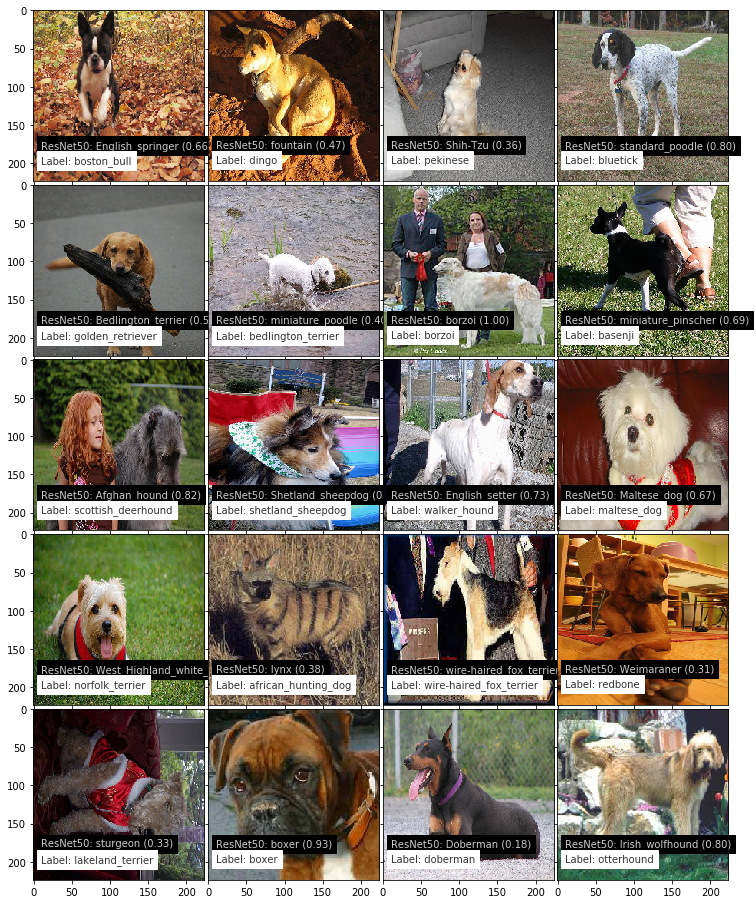

In [80]:
rn50_model = ResNet50(weights='imagenet')

max_classes = 20
cols = int(np.sqrt(max_classes))
rows = int(np.ceil(1. * max_classes / cols))

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.05)

for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values[:max_classes]):
    ax = grid[i]
    img = read_img(img_id, join(DATA_DIR, 'orig_train'), TARGET_SIZE)
    x = preprocess_input(img.copy())
    ax.imshow(img / 255.)
    x = np.expand_dims(img, axis=0)
    preds = rn50_model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name, prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'Label: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    
plt.show()

### VGG16 bottleneck features

In [85]:
POOLING = 'avg'

x_train = np.zeros((len(labels), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels.id)):
    img = read_img(img_id, join(DATA_DIR, 'orig_train'), TARGET_SIZE)
    x = vgg16.preprocess_input(img)
    x_train[i] = x
    
print('train images shape: {} size: {:,}'.format(x_train.shape, x_train.size))


10222it [00:33, 307.27it/s]

train images shape: (10222, 224, 224, 3) size: 1,538,697,216


In [95]:
train_imgs = x_train[train_idx]
valid_imgs = x_train[valid_idx]

print((train_imgs.shape, valid_imgs.shape, train_labels.shape, valid_labels.shape))

vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)

train_vgg_bf = vgg_bottleneck.predict(train_imgs, batch_size=64, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(valid_imgs, batch_size=64, verbose=1)

print('VGG train features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))


((8182, 224, 224, 3), (2040, 224, 224, 3), (8182, 120), (2040, 120))
2040/2040 [==============================] - 6s     
VGG train features shape: (8182, 512) size: 4,189,184
VGG valid features shape: (2040, 512) size: 1,044,480


### LogReg on VGG19 bottleneck features

In [113]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (train_labels * range(NUM_CLASSES)).sum(axis=1))

valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

print('validation VGG log loss {}'.format(log_loss(valid_labels, valid_probs)))
print('validation VGG accuracy {}'.format(accuracy_score((valid_labels * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

validation VGG log loss 2.3529515437904114
validation VGG accuracy 0.5759803921568627


### Xception bottleneck features

In [115]:
X_IMG_SIZE = 299
X_POOLING = 'avg'

x_train = np.zeros((len(labels), X_IMG_SIZE, X_IMG_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels.id)):
    img = read_img(img_id, join(DATA_DIR, 'orig_train'), (X_IMG_SIZE, X_IMG_SIZE))
    x = xception.preprocess_input(img)
    x_train[i] = x
    
print('train images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:59, 170.48it/s]

train images shape: (10222, 299, 299, 3) size: 2,741,571,066


In [289]:
x_test = np.zeros((len(sample_submission.id), X_IMG_SIZE, X_IMG_SIZE, 3), dtype='float32')

for i, img_id in tqdm(enumerate(sample_submission.id)):
    img = read_img(img_id, join(DATA_DIR, 'orig_test'), (X_IMG_SIZE, X_IMG_SIZE))
    x = xception.preprocess_input(img)
    x_test[i] = x
    
print('test images shape: {} size {:,}'.format(x_test.shape, x_test.size))

10357it [00:28, 362.59it/s]

test images shape: (10357, 299, 299, 3) size 2,777,778,471


In [117]:
x_train_imgs = x_train[train_idx]
x_valid_imgs = x_train[valid_idx]

print((x_train_imgs.shape, x_valid_imgs.shape, train_labels.shape, valid_labels.shape))

xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(x_train_imgs, batch_size=64, verbose=1)
valid_x_bf = xception_bottleneck.predict(x_valid_imgs, batch_size=64, verbose=1)

print('xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((8182, 299, 299, 3), (2040, 299, 299, 3), (8182, 120), (2040, 120))
2040/2040 [==============================] - 13s    
xception train bottleneck features shape: (8182, 2048) size: 16,756,736
xception valid bottleneck features shape: (2040, 2048) size: 4,177,920


In [304]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=64, verbose=1)

10357/10357 [==============================] - 80s    


### LogReg on Xception bottleneck features

In [156]:
def unhot(labels, num_classes):
    return (labels * range(num_classes)).sum(axis=1)

In [137]:
(train_labels * range(NUM_CLASSES)).sum(axis=1)

array([ 42.,  72.,  94., ...,  10.,  18.,  53.])

In [176]:
onehot(train_classes, NUM_CLASSES)
train_classes
ux = (unhot(train_labels, NUM_CLASSES))
ux.sort()

120

In [178]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (train_labels * range(NUM_CLASSES)).sum(axis=1))

x_valid_probs = logreg.predict_proba(valid_x_bf)
x_valid_preds = logreg.predict(valid_x_bf)

print('validation Xception log loss {}'.format(log_loss(valid_labels, x_valid_probs)))
print('validation Xception accuracy {}'.format(accuracy_score((valid_labels * range(NUM_CLASSES)).sum(axis=1), x_valid_preds)))

validation Xception log loss 0.6873175942605868
validation Xception accuracy 0.8490196078431372


### Use a dense model on Xception bottleneck features

In [241]:
x_dense = Sequential([
    Dropout(0.3, input_shape=xception_bottleneck.layers[-1].output_shape[1:]),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(NUM_CLASSES, activation='softmax')
])

x_dense.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
x_dense.fit(train_x_bf, train_labels, batch_size=64, epochs=2, validation_data=(valid_x_bf, valid_labels))

Train on 8182 samples, validate on 2040 samples
Epoch 1/2
8182/8182 [==============================] - 6s - loss: 3.7014 - acc: 0.2575 - val_loss: 1.6654 - val_acc: 0.8000
Epoch 2/2
8182/8182 [==============================] - 2s - loss: 1.4522 - acc: 0.6132 - val_loss: 0.5001 - val_acc: 0.8588


In [246]:
x_dense.optimizer.lr = 0.00001
x_dense.fit(train_x_bf, train_labels, batch_size=64, epochs=10, validation_data=(valid_x_bf, valid_labels))

Train on 8182 samples, validate on 2040 samples
Epoch 1/10
8182/8182 [==============================] - 3s - loss: 0.3167 - acc: 0.9000 - val_loss: 0.3933 - val_acc: 0.8995
Epoch 2/10
8182/8182 [==============================] - 2s - loss: 0.3110 - acc: 0.8977 - val_loss: 0.4008 - val_acc: 0.8961
Epoch 3/10
8182/8182 [==============================] - 2s - loss: 0.2962 - acc: 0.9036 - val_loss: 0.4059 - val_acc: 0.8892
Epoch 4/10
8182/8182 [==============================] - 2s - loss: 0.3080 - acc: 0.8987 - val_loss: 0.4150 - val_acc: 0.8907
Epoch 5/10
8182/8182 [==============================] - 2s - loss: 0.3027 - acc: 0.9005 - val_loss: 0.4161 - val_acc: 0.8956
Epoch 6/10
8182/8182 [==============================] - 2s - loss: 0.3001 - acc: 0.8990 - val_loss: 0.4029 - val_acc: 0.9005
Epoch 7/10
8182/8182 [==============================] - 2s - loss: 0.2961 - acc: 0.9050 - val_loss: 0.4202 - val_acc: 0.8863
Epoch 8/10
8182/8182 [==============================] - 2s - loss: 0.2856 - a

### Check predictions

In [ ]:
def do_clip(arr, mx):
    return np.clip(arr, (1 - mx) / 9, mx)

In [326]:
import keras 

valid_preds = x_dense.predict(valid_x_bf)
test_preds = x_dense.predict(test_x_bf)

log_loss(valid_labels, valid_preds)
#np.mean(keras.metrics.categorical_crossentropy(valid_labels, valid_preds)).eval()
# accuracy_score(un_onehot(valid_labels, NUM_CLASSES).astype('float32'), un_onehot(valid_preds, NUM_CLASSES).astype('float32'))
#valid_labels[0]
#valid_preds[0]

result = pd.DataFrame(do_clip(test_preds, 0.93), columns=selected_breed_list)
result.loc[:, 'id'] = pd.Series(sample_submission.id, index=result.index)
result.to_csv(join(DATA_DIR, 'results', 'submission.csv'), index=False)

In [322]:
pd.Series(sample_submission.id, index=result.index)

0        000621fb3cbb32d8935728e48679680e
1        00102ee9d8eb90812350685311fe5890
2        0012a730dfa437f5f3613fb75efcd4ce
3        001510bc8570bbeee98c8d80c8a95ec1
4        001a5f3114548acdefa3d4da05474c2e
5        00225dcd3e4d2410dd53239f95c0352f
6        002c2a3117c2193b4d26400ce431eebd
7        002c58d413a521ae8d1a5daeb35fc803
8        002f80396f1e3db687c5932d7978b196
9        0036c6bcec6031be9e62a257b1c3c442
10       0041940322116ae58c38130f5a6f71f9
11       0042d6bf3e5f3700865886db32689436
12       004476c96f575879af4af471af65cae8
13       00485d47de966a9437ad3b33ac193b6f
14       00496f65de6cc319145ce97bd6e90360
15       004bf14426d1a830d459a9e0c0721309
16       004c3721eb88358f462cdcec6b2380b7
17       00559f56aab7e0a7749220f6aed65162
18       005b281f1a4d6f29d527c9585e9bd33c
19       005b6c6c76fefd6b458ef6fb6e54da6e
20       006870b49353779b25eeb91fed43c31a
21       0068f3a21b159ece126a28580cdad7a0
22       0069b1cc4546fc98f84f981bf9a0696a
23       0077bc3c63486ff09d3774d95